**Installation of SimPy""
If not available**

In [1]:
# Window
!python -m pip install simpy
!python -m pip install numpy
!python -m pip install matplotlib


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Import of required modules**

In [2]:
import simpy
import numpy as np
import numpy.random as random

**Parameters settings**

In [3]:
MAXSIMTIME              = 100000
VERBOSE                 = False
LAMBDA                  = 3.8
MU                      = 8.0
POPULATION              = 50000000
SERVICE_DISCIPLINE      = 'FIFO'
LOGGED                  = True
PLOTTED                 = True

**Discrete-Event Simulation model**


**The definition of a job**.

The properties of a job are


1. job execution time
2. job arrival time

In [4]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

**Disciplines**
Different queue disciplines can be defined here.


1.   Shortest Job First (SJF)
2.   List item



In [5]:
def SJF( job ):
    return job.duration

**The definition of server**

 There are 3 arguments needed for a server:
 1. env: SimPy environment
 2. queue discipline: 
   - FIFO: First In First Out
   - SJF : Shortest Job  

In [6]:
class Server:
    def __init__(self, env, strat = 'FIFO', name = 1):
        self.name = name
        
        self.env = env
        self.strat = strat
        self.Jobs = list(())
              
        self.serversleeping = None
        
        ''' statistics '''
        self.waitingTime = 0
        self.serviceTime = 0
        self.responseTime = 0
        self.idleTime = 0
        self.jobsDone = 0

        ''' register a new server process '''
        env.process( self.serve() )

    def nJobs(self):
        return len(self.Jobs)

    def serve(self):
        while True:
            # do nothing, just change server to idle
            # and then yield a wait event which takes infinite time
            if len( self.Jobs ) == 0 :
                self.serversleeping = self.env.process( self.waiting( self.env ))
                t1 = self.env.now
                yield self.serversleeping
                # accumulate the server idle time
                self.idleTime += self.env.now - t1
            else:
                # get the first job to be served
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )

                if LOGGED:
                    if self.name == 1:
                        qlog1.write( '%.4f\t%d\t%d\n' 
                            % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)) )
                    else:
                        qlog2.write( '%.4f\t%d\t%d\n' 
                            % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)) )

                ''' sum up the waiting time'''
                self.waitingTime += self.env.now - j.arrtime
                ''' sum up the service time'''
                self.serviceTime += j.duration
                ''' sum up the response time'''
                self.responseTime += (self.env.now - j.arrtime) + j.duration

                ''' yield an event for the job finish'''
                yield self.env.timeout( j.duration )

                ''' sum up the jobs done '''
                self.jobsDone += 1

    def waiting(self, env):
        try:
            if VERBOSE:
                print( 'Server', self.name, 'is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                print('Server', self.name ,'waken up and works at %.2f' % self.env.now )

**The arrival process**

The arrival process is exponentially distributed which is parameterized by
1. number of servers
2. maximum number of population
3. arrival rate $\lambda$
4. service rate $\mu$
*Note that, the implementation of the arrival process embeds both arrival and service distributions.*

In [7]:
class JobGenerator:
    def __init__(self, env, server1, server2, nrjobs = 10000000, lam = 5, mu = 8):
        self.server1 = server1
        self.server2 = server2

        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam;
        self.servicetime = 1/mu;
        env.process( self.generatejobs(env) )
        
    def generatejobs(self, env):
        i = 1
        while True:
            # yield an event for new job arrival
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            # generate service time and add job to the list
            job_duration = random.exponential( self.servicetime )

            # choose server randomly 50%
            server = 1
            temp = random.random()

            if temp < 0.5:
                server = 1
            else:
                server = 2

            if server == 1:
                self.server1.Jobs.append( Job('Job %s' %i, env.now, job_duration) )
            else:
                self.server2.Jobs.append( Job('Job %s' %i, env.now, job_duration) )

            if VERBOSE:
                print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    %( i, env.now, job_duration, job_interarrival ) )

            i += 1

            if server == 1:
                ''' if server is idle, wake it up'''
                if not self.server1.serversleeping.triggered:
                    self.server1.serversleeping.interrupt( 'Wake up server 1, please.' )
            else:
                ''' if server is idle, wake it up'''
                if not self.server2.serversleeping.triggered:
                    self.server2.serversleeping.interrupt( 'Wake up server 2, please.' )

**Open the log file**

If requested.

In [8]:
if LOGGED:
    qlog1 = open( 'parallel-mm1-l%d-m%d-1.csv' % (LAMBDA,MU), 'w' )
    qlog1.write( '0\t0\t0\n' )
    qlog2 = open( 'parallel-mm1-l%d-m%d-2.csv' % (LAMBDA,MU), 'w' )
    qlog2.write( '0\t0\t0\n' )

**Start SimPy environment**

In [9]:
env = simpy.Environment()

MyServer1 = Server( env, SERVICE_DISCIPLINE, 1 )
MyServer2 = Server( env, SERVICE_DISCIPLINE, 2 )

MyJobGenerator = JobGenerator( env, MyServer1, MyServer2, POPULATION, LAMBDA, MU )

**Run the simulation** 

In [10]:
env.run( until = MAXSIMTIME )

**Close the log file**

In [11]:
if LOGGED:
    qlog1.close()
    qlog2.close()

**Print some statistics**

In [12]:
# theory variables
RHO = LAMBDA/MU
RHO_1 = (LAMBDA / 2) / MU
RHO_2 = (LAMBDA / 2) / MU

UTILIZATION_1 = RHO_1
UTILIZATION_2 = RHO_2
UTILIZATION = 1 - (1-UTILIZATION_1)*(1-UTILIZATION_2)

MEAN_WAITING_TIME_1 = RHO_1**2/((1-RHO_1)*LAMBDA)
MEAN_WAITING_TIME_2 = RHO_2**2/((1-RHO_2)*LAMBDA)

MEAN_SERVICE_TIME_1 = 1 / MU
MEAN_SERVICE_TIME_2 = 1 / MU

MEAN_RESPONSE_TIME_1 = RHO_1**2/((1-RHO_1)*LAMBDA) + 1/MU
MEAN_RESPONSE_TIME_2 = RHO_2**2/((1-RHO_2)*LAMBDA) + 1/MU

MEAN_NUMBER_JOB_1 = RHO_1 / (1 - RHO_1)
MEAN_NUMBER_JOB_2 = RHO_2 / (1 - RHO_2)

print('Arrivals 1               : %d' % (MyServer1.jobsDone) )
print('Arrivals 2               : %d\n' % (MyServer2.jobsDone) )


print('Idle time 1              : %d' % (MyServer1.idleTime))
print('Idle time 2              : %d\n' % (MyServer2.idleTime))


print('Waiting time 1           : %d' % (MyServer1.waitingTime))
print('Waiting time 2           : %d\n' % (MyServer2.waitingTime))


print('Job done 1               : %d' % (MyServer1.jobsDone))
print('Job done 2               : %d\n' % (MyServer2.jobsDone))

# U
U1 = (1.0-MyServer1.idleTime/MAXSIMTIME)
U2 = (1.0-MyServer2.idleTime/MAXSIMTIME)
U = (1.0-(MyServer1.idleTime/MAXSIMTIME)*(MyServer2.idleTime/MAXSIMTIME))
print('Utilization')
print('U                        : %.2f/%.2f' 
    % (U, UTILIZATION ) )
print('U (1)                    : %.2f/%.2f' 
    % (U1, UTILIZATION_1) )
print('U (2)                    : %.2f/%.2f\n' 
    % (U2, UTILIZATION_2) )
    
# E[w]
E_W_1 = (MyServer1.waitingTime/MyServer1.jobsDone)
E_W_2 = (MyServer2.waitingTime/MyServer2.jobsDone)
print('Mean waiting time')
print('E[w]                     : %.2f/%.2f' 
    %  ((E_W_1+E_W_2)/2, (MEAN_WAITING_TIME_1+MEAN_WAITING_TIME_2)/2 ) )
print('E[w] (1)                 : %.2f/%.2f' 
    %  (E_W_1, MEAN_WAITING_TIME_1) )
print('E[w] (2)                 : %.2f/%.2f\n' 
    %  (E_W_2, MEAN_WAITING_TIME_2) )

# E[s]
E_S_1 = (MyServer1.serviceTime/MyServer1.jobsDone)
E_S_2 = (MyServer2.serviceTime/MyServer2.jobsDone)
print('Mean service time')
print('E[s]                     : %.2f/%.2f' 
    %  ((E_S_1+E_S_2)/2, (MEAN_SERVICE_TIME_1+MEAN_SERVICE_TIME_2)/2) )
print('E[s] (1)                 : %.2f/%.2f' 
    %  (E_S_1, MEAN_SERVICE_TIME_1) )
print('E[s] (2)                 : %.2f/%.2f\n' 
    %  (E_S_2, MEAN_SERVICE_TIME_2) )

# E[r]
E_R_1 = (MyServer1.responseTime/MyServer1.jobsDone)
E_R_2 = (MyServer2.responseTime/MyServer2.jobsDone)
print('Mean response time')
print('E[r]                     : %.2f/%.2f' 
    %  ((E_R_1+E_R_2)/2, (MEAN_RESPONSE_TIME_1+MEAN_RESPONSE_TIME_2)/2) )
print('E[r] (1)                 : %.2f/%.2f' 
    %  (E_R_1, MEAN_RESPONSE_TIME_1) )
print('E[r] (2)                 : %.2f/%.2f\n' 
    %  (E_R_2, MEAN_RESPONSE_TIME_2) )

# E[n]
E_N_1 = E_R_1*(MyServer1.jobsDone/MAXSIMTIME)
E_N_2 = E_R_2*(MyServer2.jobsDone/MAXSIMTIME)
print('Mean number of jobs')
print('E[n]                     : %.2f/%.2f' 
    % ((E_N_1+E_N_2)/2, (MEAN_NUMBER_JOB_1+MEAN_NUMBER_JOB_2)/2 ) )
print('E[n] (1)                 : %.2f/%.2f' 
    % (E_N_1, MEAN_NUMBER_JOB_1 ) )
print('E[n] (2)                 : %.2f/%.2f' 
    % (E_N_2, MEAN_NUMBER_JOB_2 ) )

Arrivals 1               : 190547
Arrivals 2               : 189564

Idle time 1              : 76201
Idle time 2              : 76343

Waiting time 1           : 7365
Waiting time 2           : 7327

Job done 1               : 190547
Job done 2               : 189564

Utilization
U                        : 0.42/0.42
U (1)                    : 0.24/0.24
U (2)                    : 0.24/0.24

Mean waiting time
E[w]                     : 0.04/0.02
E[w] (1)                 : 0.04/0.02
E[w] (2)                 : 0.04/0.02

Mean service time
E[s]                     : 0.12/0.12
E[s] (1)                 : 0.12/0.12
E[s] (2)                 : 0.12/0.12

Mean response time
E[r]                     : 0.16/0.14
E[r] (1)                 : 0.16/0.14
E[r] (2)                 : 0.16/0.14

Mean number of jobs
E[n]                     : 0.31/0.31
E[n] (1)                 : 0.31/0.31
E[n] (2)                 : 0.31/0.31


**Plot the statistics**

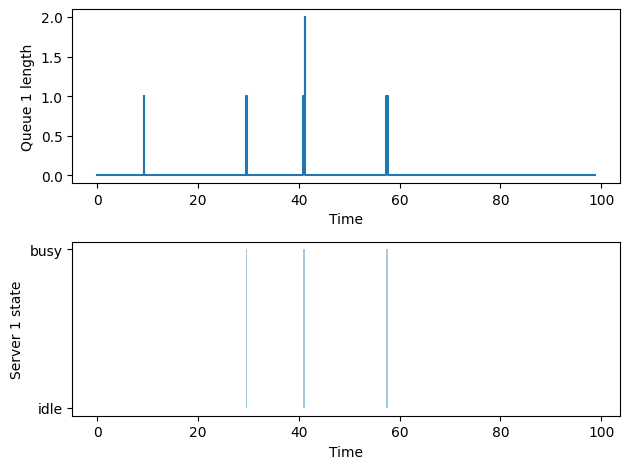

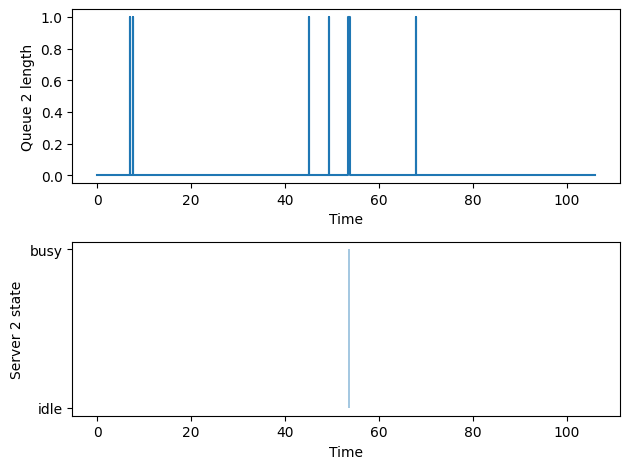

In [13]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'parallel-mm1-l%d-m%d-1.csv' % (LAMBDA,MU), delimiter = '\t' )
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue 1 length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server 1 state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    #plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()

if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'parallel-mm1-l%d-m%d-2.csv' % (LAMBDA,MU), delimiter = '\t' )
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue 2 length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server 2 state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    #plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()